# Customer Segmentation based on Uplift Modeling

## 1. Load Data

In [ ]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv('data/campaign_data_with_uplift.csv')
df.head()

,customer_id,age,gender,income,region,tenure_years,received_campaign,spend_last_month,channel,product_category,responded,spend_this_month,is_high_value,days_since_last_purchase,credit_score,customer_segment,treatment_str,uplift_score
0,CUST00001,56,Female,111974,North,4.5,0,616.04,Email,Loans,1,771.72,0,156,664,1,control,-0.027778
1,CUST00002,69,Male,42291,South,5.7,0,171.21,Email,Loans,0,171.21,0,185,732,2,control,0.010606
2,CUST00003,46,Female,70585,North,5.7,0,280.33,SMS,Loans,0,280.33,0,41,715,0,control,0.188525
3,CUST00004,32,Male,78626,East,9.3,0,143.79,SMS,Loans,0,143.79,0,201,725,0,control,0.100000
4,CUST00005,60,Female,64871,South,0.0,1,67.43,Email,Loans,1,221.13,0,50,719,3,treatment,0.188525


## 2. Rule-Based Uplift Segmentation

In [ ]:
def label_customer(row):
    uplift = row['uplift_score']
    resp_treated = row['received_campaign']
    resp_control = row['responded']

    if uplift > 0 and resp_treated == 1 and resp_control == 0:
        return 'Persuadables'
    elif resp_treated == 1 and resp_control == 1:
        return 'Sure Things'
    elif resp_treated == 0 and resp_control == 0:
        return 'Lost Causes'
    elif uplift < 0:
        return 'Do Not Disturbs'
    else:
        return 'Unclassified'

df['segment'] = df.apply(label_customer, axis=1)

## 3. Segment Summary

In [ ]:
segment_summary = df.groupby('segment').agg({
    'age': ['mean', 'median'],
    'income': ['mean', 'median'],
    'spend_last_month': ['mean', 'median'],
    'spend_this_month': ['mean', 'median'],
    'gender': lambda x: x.value_counts(normalize=True).to_dict()
})
segment_summary.columns = ['_'.join(col).strip() for col in segment_summary.columns.values]
segment_summary.reset_index(inplace=True)
segment_summary.head()

,segment,age_mean,age_median,income_mean,income_median,spend_last_month_mean,spend_last_month_median,spend_this_month_mean,spend_this_month_median,gender_<lambda>
0,Do Not Disturbs,41.991525,42.0,74122.177966,70515.0,260.930508,228.145,276.464576,241.85,"{'Female': 0.5, 'Male': 0.5}"
1,Lost Causes,43.426634,43.0,69724.590218,69399.0,197.194862,135.760,197.194862,135.76,"{'Male': 0.4886970817920263, 'Female': 0.48376..."
2,Persuadables,43.603909,44.0,68966.554012,68948.5,197.741800,140.380,197.741800,140.38,"{'Male': 0.4876543209876543, 'Female': 0.48662..."
3,Sure Things,44.389027,45.0,71821.660848,73272.0,209.387007,136.040,309.265661,247.73,"{'Male': 0.5062344139650873, 'Female': 0.47132..."
4,Unclassified,45.625000,44.5,74314.721154,73848.0,189.542885,114.170,286.768173,221.90,"{'Male': 0.5480769230769231, 'Female': 0.42307..."


## 4. Visualizations

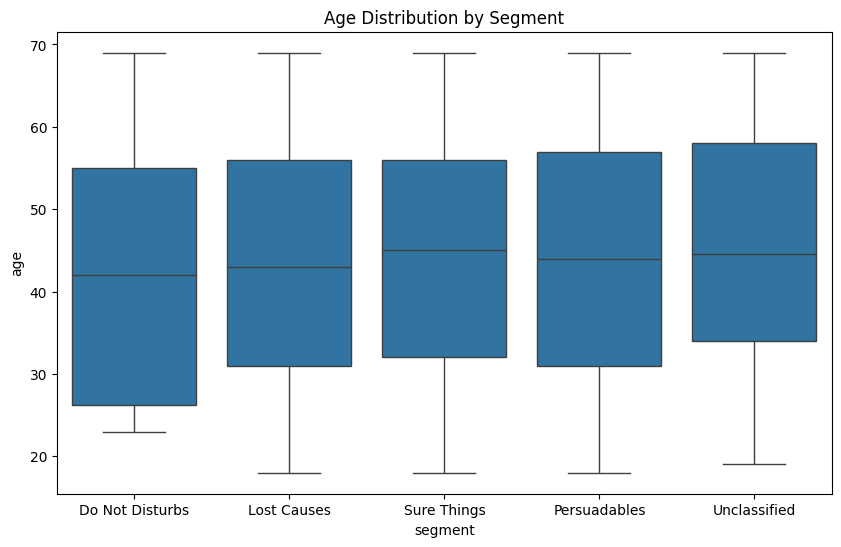

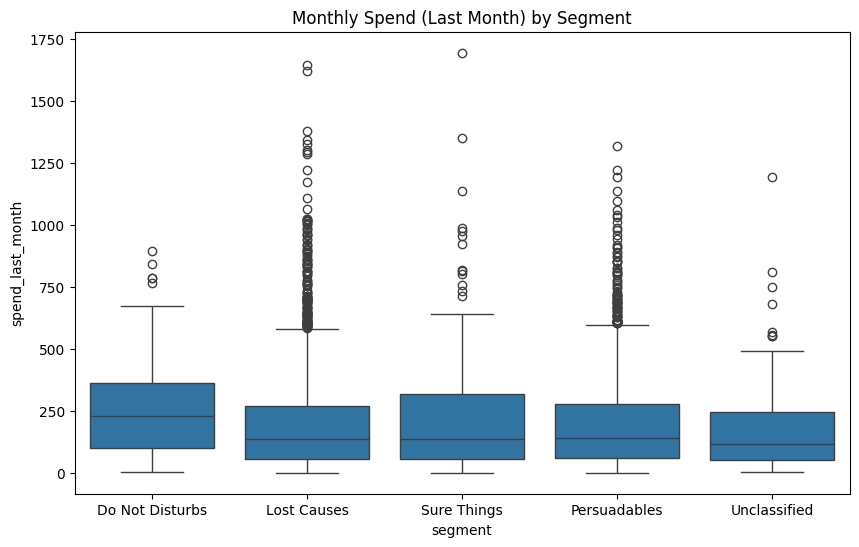

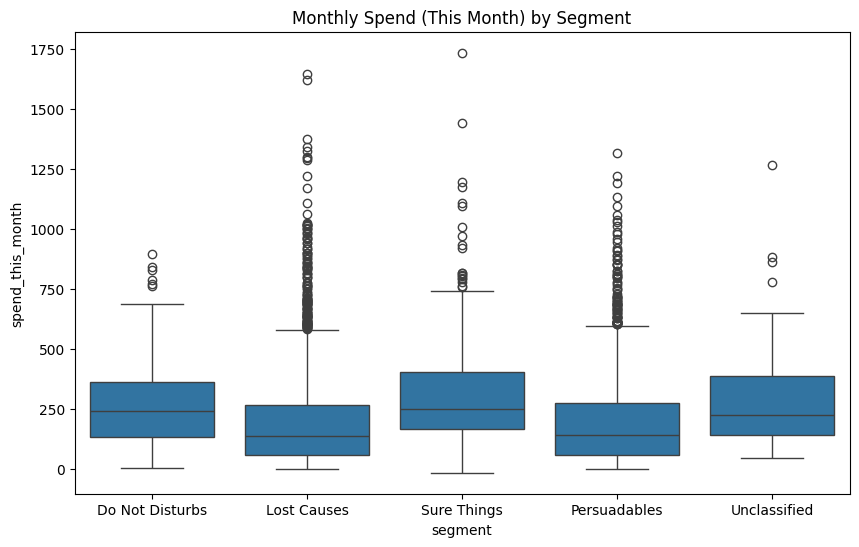

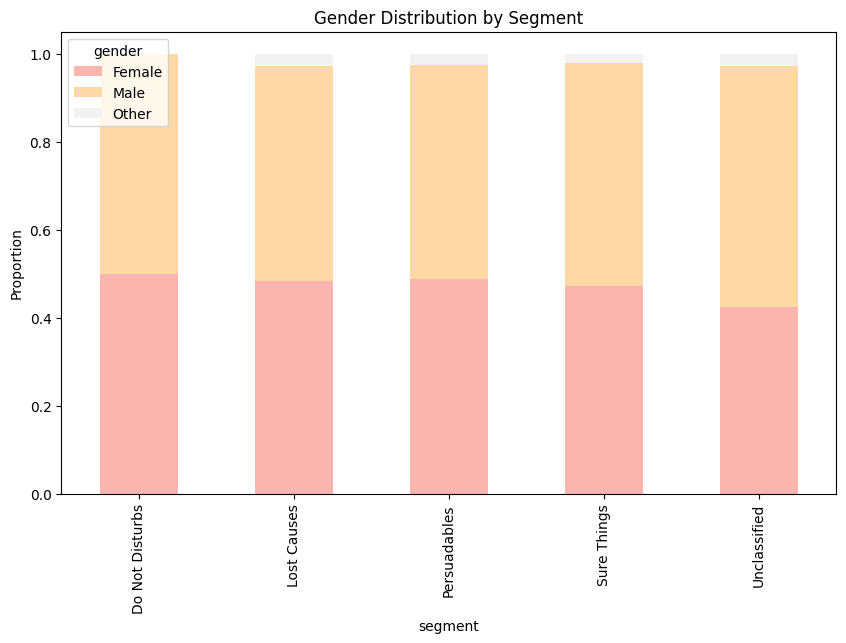

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Age distribution by segment
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='segment', y='age')
plt.title("Age Distribution by Segment")
plt.show()

# Monthly spend (last month) by segment
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='segment', y='spend_last_month')
plt.title("Monthly Spend (Last Month) by Segment")
plt.show()

# Spend this month by segment
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='segment', y='spend_this_month')
plt.title("Monthly Spend (This Month) by Segment")
plt.show()

# Gender distribution by segment
gender_dist = df.groupby(['segment', 'gender']).size().unstack().apply(lambda x: x / x.sum(), axis=1)
gender_dist.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Pastel1')
plt.title("Gender Distribution by Segment")
plt.ylabel("Proportion")
plt.show()

Nothing valuable from this part and visualization

## 5. Statistical Tests

In [ ]:

from scipy.stats import f_oneway, chi2_contingency

# ANOVA: Check age difference across segments
anova_age = f_oneway(
    df[df['segment'] == 'Persuadables']['age'],
    df[df['segment'] == 'Sure Things']['age'],
    df[df['segment'] == 'Lost Causes']['age'],
    df[df['segment'] == 'Do Not Disturbs']['age']
)
print("ANOVA (age):", anova_age)

ANOVA (age): F_onewayResult(statistic=np.float64(0.9148219379011953), pvalue=np.float64(0.43280557961049293))
Chi-squared (gender): Chi2ContingencyResult(statistic=np.float64(5.523907723990757), pvalue=np.float64(0.700389803639323), dof=8, expected_freq=array([[  56.994 ,   57.9616,    3.0444],
       [1175.139 , 1195.0896,   62.7714],
       [ 938.952 ,  954.8928,   50.1552],
       [ 193.683 ,  196.9712,   10.3458],
       [  50.232 ,   51.0848,    2.6832]]))


✅ **Purpose**:

Tests if mean age is significantly different across segments:

* Null Hypothesis (H₀): All segments have the same average age

* Alternative (H₁): At least one segment has a different average age

✅ **Interpretation**:

* F = 0.9148: A low test statistic

* p-value = 0.4328 → > 0.05

✅ **Conclusion**:

* Fail to reject the null hypothesis

* There is no statistically significant difference in age across the segments



In [ ]:
# Chi-squared test for gender distribution
contingency_table = pd.crosstab(df['segment'], df['gender'])
chi2_result = chi2_contingency(contingency_table)
print("Chi-squared (gender):", chi2_result)

Chi-squared (gender): Chi2ContingencyResult(statistic=np.float64(5.523907723990757), pvalue=np.float64(0.700389803639323), dof=8, expected_freq=array([[  56.994 ,   57.9616,    3.0444],
       [1175.139 , 1195.0896,   62.7714],
       [ 938.952 ,  954.8928,   50.1552],
       [ 193.683 ,  196.9712,   10.3458],
       [  50.232 ,   51.0848,    2.6832]]))


✅ Purpose:
Tests if gender distribution differs by segment:

* Null Hypothesis (H₀): Gender proportions are the same across segments

* Alternative (H₁): Gender proportions differ across segments

✅ Interpretation:

* Chi² = 5.524, with 8 degrees of freedom

* p-value = 0.7004 > 0.05

✅ Conclusion:
* Fail to reject the null hypothesis

* There is no significant relationship between segment and gender

* Gender is not a useful predictor of uplift-based segmentation in your dataset

## 6. Feature Distributions by Segment

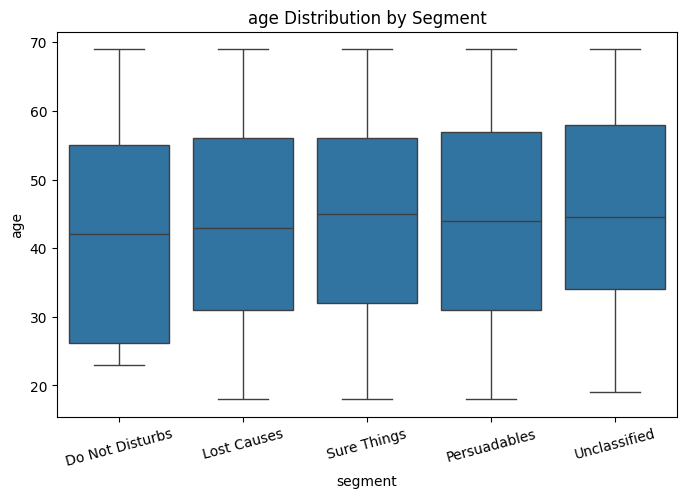

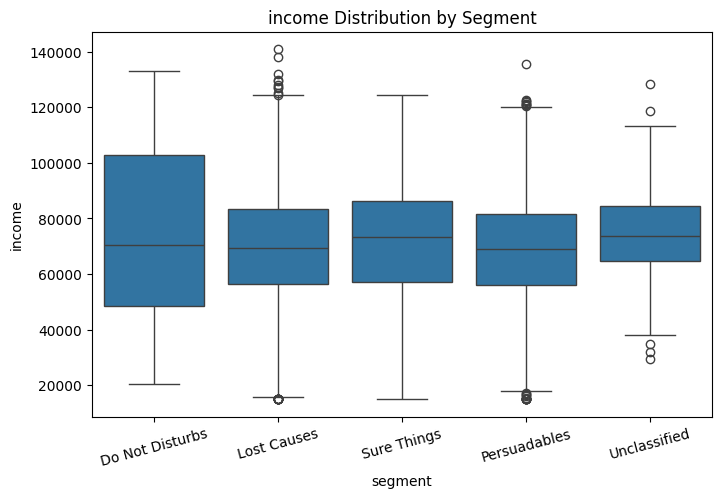

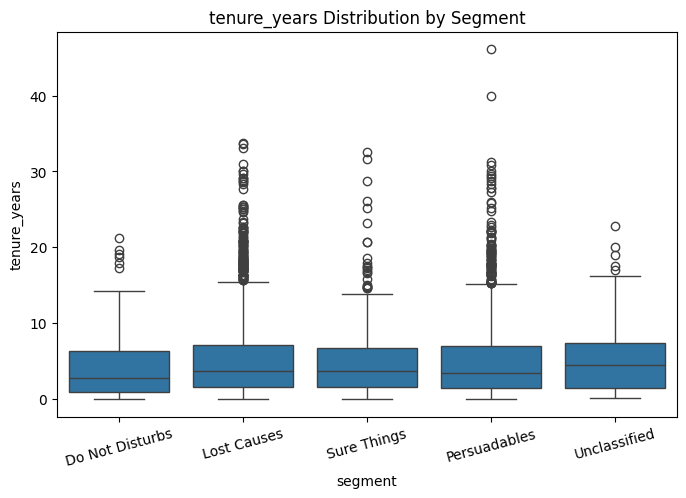

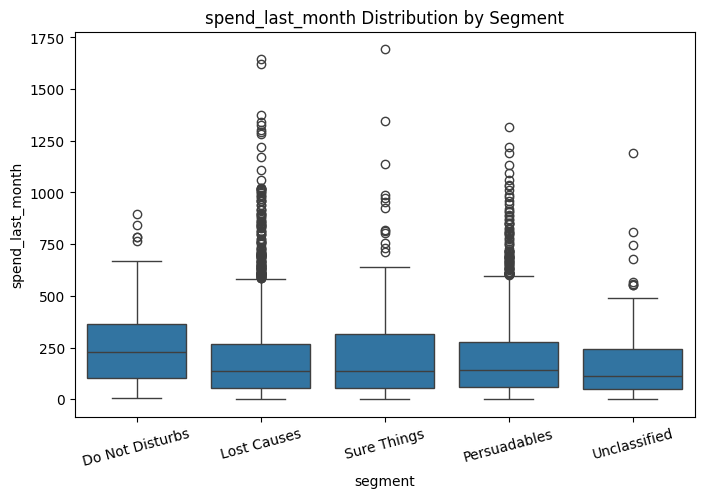

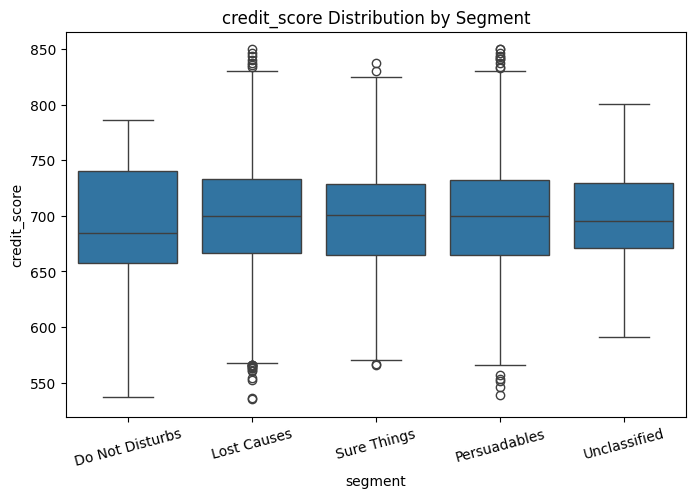

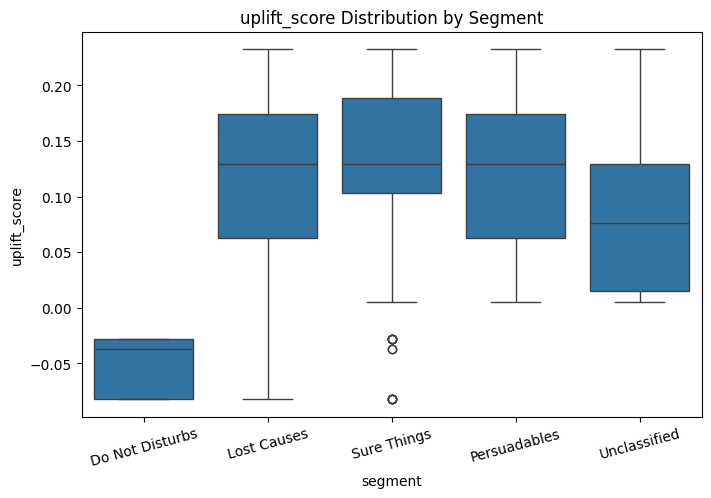

In [ ]:
features = ['age', 'income', 'tenure_years', 'spend_last_month', 'credit_score', 'uplift_score']

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='segment', y=feature)
    plt.title(f'{feature} Distribution by Segment')
    plt.xticks(rotation=15)
    plt.show()


    # the results does not show anything insightful

<Axes: xlabel='segment'>

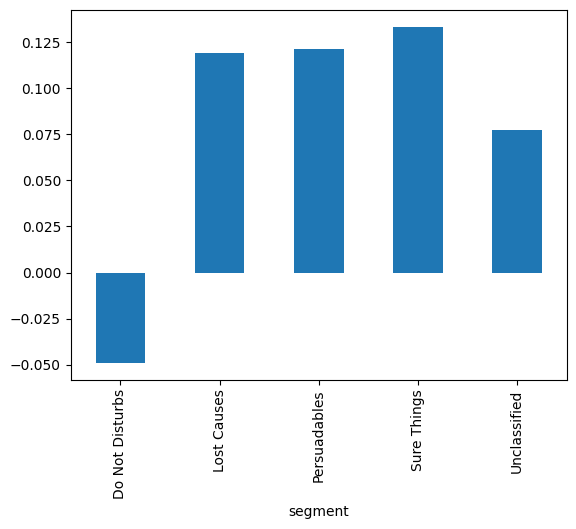

In [ ]:
df.groupby("segment")["uplift_score"].mean().plot(kind='bar')

In [ ]:
df.head()

,customer_id,age,gender,income,region,tenure_years,received_campaign,spend_last_month,channel,product_category,...,spend_this_month,is_high_value,days_since_last_purchase,credit_score,customer_segment,treatment_str,uplift_score,segment,pca_1,pca_2
0,CUST00001,56,Female,111974,North,4.5,0,616.04,Email,Loans,...,771.72,0,156,664,1,control,-0.027778,Do Not Disturbs,-2.291307,-1.122971
1,CUST00002,69,Male,42291,South,5.7,0,171.21,Email,Loans,...,171.21,0,185,732,2,control,0.010606,Lost Causes,0.361126,0.622966
2,CUST00003,46,Female,70585,North,5.7,0,280.33,SMS,Loans,...,280.33,0,41,715,0,control,0.188525,Lost Causes,0.733900,0.033378
3,CUST00004,32,Male,78626,East,9.3,0,143.79,SMS,Loans,...,143.79,0,201,725,0,control,0.100000,Lost Causes,-0.680260,0.914904
4,CUST00005,60,Female,64871,South,0.0,1,67.43,Email,Loans,...,221.13,0,50,719,3,treatment,0.188525,Sure Things,1.737782,-0.118801


In [ ]:
# Save Outputs

df.to_csv("data/campaign_data_segmentation.csv", index=False)